In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("dataset_2023_2025.csv")

df.head()

,city_id,city_name,lat,lon,datetime,pm10,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,doy_sin,doy_cos,hour_sin,hour_cos,pm2_5
0,7701354,Azimpur,23.7298,90.3854,2023-01-01 00:00:00,220.7,1190.0,87.2,38.2,3.0,0.017202,0.999852,0.000000,1.000000,154.1
1,7701354,Azimpur,23.7298,90.3854,2023-01-01 01:00:00,213.7,1227.0,84.9,35.5,4.0,0.017202,0.999852,0.258819,0.965926,149.0
2,7701354,Azimpur,23.7298,90.3854,2023-01-01 02:00:00,205.4,1276.0,81.6,31.9,5.0,0.017202,0.999852,0.500000,0.866025,143.4
3,7701354,Azimpur,23.7298,90.3854,2023-01-01 03:00:00,201.6,1259.0,73.7,29.6,18.0,0.017202,0.999852,0.707107,0.707107,140.6
4,7701354,Azimpur,23.7298,90.3854,2023-01-01 04:00:00,193.2,1111.0,63.0,33.0,44.0,0.017202,0.999852,0.866025,0.500000,134.6


In [2]:
import unicodedata

# Function to remove accents
def normalize_name(name):
    if not isinstance(name, str):
        return name
    # Decompose the unicode characters (e.g., 'ī' becomes 'i' + '◌̄')
    normalized = unicodedata.normalize('NFD', name)
    # Filter out the non-spacing mark (the accents) and join back
    return "".join([c for c in normalized if not unicodedata.combining(c)])

df['city_name'] = df['city_name'].apply(normalize_name)

In [3]:
unique_cities = df[['city_id', 'city_name']].drop_duplicates()
print("Unique City IDs and Names:")
print(unique_cities)

Unique City IDs and Names:
        city_id            city_name
0       7701354              Azimpur
25392   1185283            Badarganj
50784   1185274           Baniachang
76176   1336137              Barisal
101568  1209562                 Bera
126960  1185263        Bhairab Bazar
152352  1185262            Bheramara
177744  1336136                Bhola
203136  1477498            Bhandaria
228528  1185260  Bhatpara Abhaynagar
253920  1337233                Bogra
279312  1210565          Burhanuddin
304704  1185276             Bajitpur
330096  1185270            Bandarban
355488  1207047       Char Bhadrasan
380880  1185249         Chhagalnaiya
406272  1185254              Chhatak
431664  1185247             Chilmari
457056  1205733           Chittagong
482448  1185186              Comilla
507840  1336134          Cox’s Bazar
533232  1185241                Dhaka
558624  1203891             Dinajpur
584016  1185100                Dohar
609408  1203344             Faridpur
634800  641

In [4]:
#  Isolate city metadata and save to a separate CSV
cities_df = df[['city_id', 'city_name', 'lat', 'lon']].drop_duplicates()

# Save to CSV
cities_df.to_csv("cities.csv", index=False)

print("\nSuccess: 'cities.csv' has been created in your local directory.")


Success: 'cities.csv' has been created in your local directory.


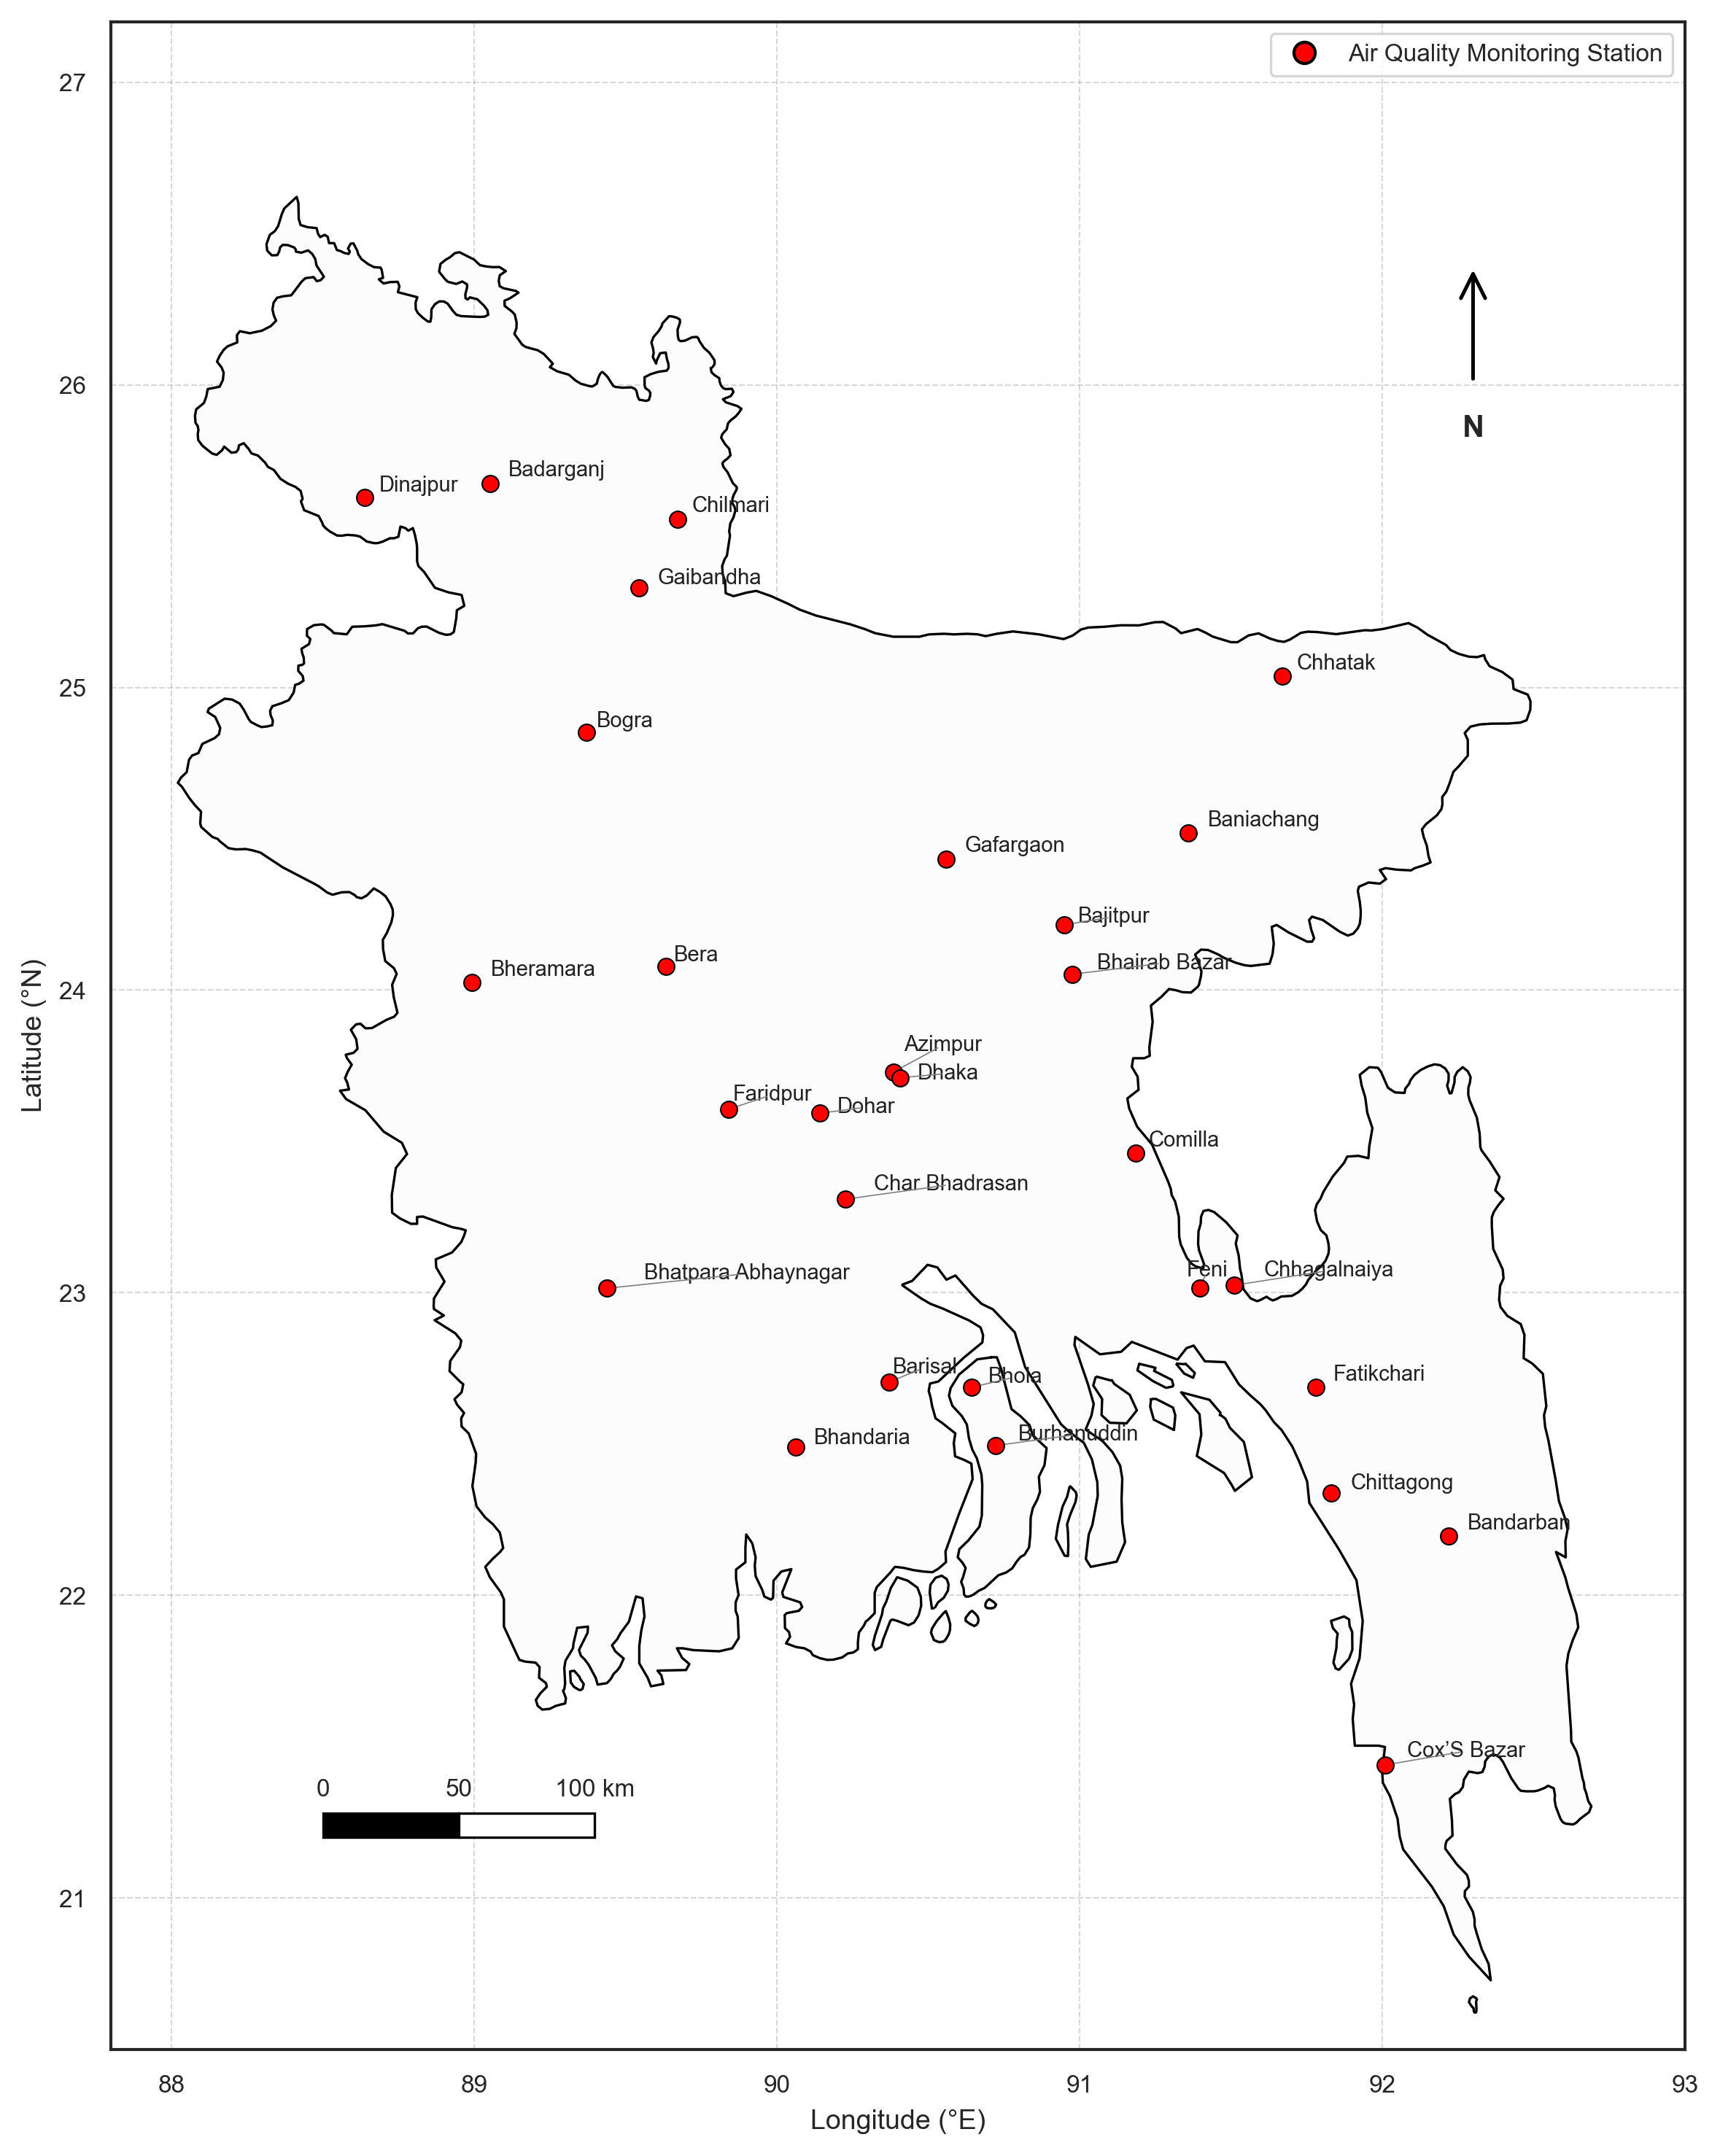

In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Rectangle, FancyArrowPatch
from matplotlib.lines import Line2D
from adjustText import adjust_text


# 1. Load data
cities_df = pd.read_csv("cities.csv")
bd = gpd.read_file("bangladesh.geojson")

fig, ax = plt.subplots(figsize=(8, 10), dpi=300)

# 2. Plot Bangladesh
bd.boundary.plot(ax=ax, color='black', linewidth=0.8, zorder=2)
bd.plot(ax=ax, color='#fcfcfc', zorder=1) 

# 3. Plot stations
ax.scatter(cities_df['lon'], cities_df['lat'], s=30, c='red', 
           edgecolor='black', linewidth=0.5, zorder=5)

# 4. ADD CITY NAMES WITH OVERLAP PROTECTION
texts = []
for _, row in cities_df.iterrows():
    # .title() makes "DHAKA" -> "Dhaka"
    texts.append(ax.text(row['lon'], row['lat'], row['city_name'].title(), 
                         fontsize=7, fontweight='normal', color='#222222'))

# Automatically repel labels from points and each other
adjust_text(texts, 
            only_move={'points':'y', 'text':'xy'}, # Prioritize moving text
            expand_text=(1.2, 1.2), 
            arrowprops=dict(arrowstyle="-", color='gray', lw=0.4))

# 5. FIXED SCALE BAR (Text exactly above the segments)
sb_x, sb_y = 88.5, 21.2  
sb_km = 100
deg_per_km = 1 / 111.32 
sb_deg = sb_km * deg_per_km

ax.add_patch(Rectangle((sb_x, sb_y), sb_deg/2, 0.08, color='black', zorder=6))
ax.add_patch(Rectangle((sb_x + sb_deg/2, sb_y), sb_deg/2, 0.08, color='white', ec='black', zorder=6))

# Precise text placement using 'va' (vertical alignment) to avoid line overlap
ax.text(sb_x, sb_y + 0.12, '0', fontsize=8, ha='center', va='bottom')
ax.text(sb_x + sb_deg/2, sb_y + 0.12, '50', fontsize=8, ha='center', va='bottom')
ax.text(sb_x + sb_deg, sb_y + 0.12, '100 km', fontsize=8, ha='center', va='bottom')

# 6. Final Polish (North Arrow & Grid)
arrow_x, arrow_y = 92.3, 26.0
arrow = FancyArrowPatch((arrow_x, arrow_y), (arrow_x, arrow_y + 0.4),
                        arrowstyle='->', mutation_scale=20, color='black', linewidth=1.2)
ax.add_patch(arrow)
ax.text(arrow_x, arrow_y - 0.1, 'N', ha='center', va='top', fontsize=10, fontweight='bold')

ax.grid(True, linestyle='--', alpha=0.3, color='gray', linewidth=0.5)
ax.set_xticks([88, 89, 90, 91, 92, 93])
ax.set_yticks([21, 22, 23, 24, 25, 26, 27])
ax.tick_params(labelsize=8)
ax.set_xlabel('Longitude (°E)', fontsize=9, fontweight='normal')
ax.set_ylabel('Latitude (°N)', fontsize=9, fontweight='normal')

# 7. Clean Legend
legend_elements = [Line2D([0], [0], marker='o', color='none', label='Air Quality Monitoring Station',
                          markerfacecolor='red', markeredgecolor='black', markersize=7)]
ax.legend(handles=legend_elements, loc='upper right', frameon=True, fontsize=8)

ax.set_xlim(87.8, 93.0)
ax.set_ylim(20.5, 27.2)
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig("Fig_BD_Stations_Final.tiff", dpi=600, pil_kwargs={"compression": "tiff_lzw"})
plt.show()